In [1]:
import os, pickle
import pandas as pd
import numpy as np
# 
import matplotlib.pyplot as plt
from IPython.display import display
# 
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 
import xgboost as xgb
from xgboost import plot_importance

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load combined features with label

In [2]:
# pdf_features_label = pd.read_pickle(os.path.join("features", "pdf_features_label.pkl.bz2"), compression="bz2")
pdf_features_label = pd.read_csv(os.path.join("features", "pdf_features_label.csv.bz2"), compression="bz2")
meta_cols = ["SK_ID_CURR", "TARGET", "tvt_code"]
ls_features = [cname for cname in pdf_features_label.columns if cname not in meta_cols]

# 
print("Number of features: {}".format(len(ls_features)))
print(pdf_features_label.shape)
display(pdf_features_label.head().T)

Number of features: 889
(356255, 892)


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
tvt_code,train,train,train,train,train
is_FLAG_EMP_PHONE,1,1,1,1,1
is_FLAG_WORK_PHONE,0,0,1,0,0
is_FLAG_PHONE,1,1,1,0,0
is_FLAG_EMAIL,0,0,0,0,0
is_REG_REGION_NOT_LIVE_REGION,0,0,0,0,0
is_REG_REGION_NOT_WORK_REGION,0,0,0,0,0


In [3]:
pdf_features_label["tvt_code"].value_counts()

train          216948
kaggle_test    48744 
test           46127 
val            44436 
Name: tvt_code, dtype: int64

# Modeling

In [4]:
version = "v06"

In [5]:
def get_Xy_from_pdf(pdf_input, ls_features, tvt_code):
    pdf_data = pdf_input[pdf_input["tvt_code"] == tvt_code].copy()
    
    #
    X = pdf_data[ls_features]
    y = pdf_data["TARGET"]
    
    return (X, y)

# 
X_train, y_train = get_Xy_from_pdf(pdf_features_label, ls_features, "train")
X_val, y_val = get_Xy_from_pdf(pdf_features_label, ls_features, "val")
X_test, y_test = get_Xy_from_pdf(pdf_features_label, ls_features, "test")

In [6]:
%%time
param_init = {
    "objective": "binary:logistic", 
    "booster": "gbtree", 
    "max_depth": 4, # default: 3 only for depthwise
    "n_estimators": 1000, # default: 500  
    "learning_rate": 0.025, # default: 0.05 
    "subsample": 0.7, 
    "colsample_bytree": 0.6,  # default:  1.0
    "colsample_bylevel": 0.5, # default: 1.0
    "random_state": 0,
    
    #
    "silent": True, 
    "n_jobs": 16, 
    
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default depthwise
}

param_fit = {
    "eval_metric": "auc", 
    "early_stopping_rounds": 500, # default: 100
    "verbose": 200,
    "eval_set": [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
}

xgb_model = xgb.XGBClassifier(**param_init)
xgb_model.fit(X_train, y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result

[0]	validation_0-auc:0.69888	validation_1-auc:0.691103	validation_2-auc:0.701235
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.771754	validation_1-auc:0.755647	validation_2-auc:0.766855
[400]	validation_0-auc:0.795841	validation_1-auc:0.771042	validation_2-auc:0.780717
[600]	validation_0-auc:0.809062	validation_1-auc:0.776146	validation_2-auc:0.785671
[800]	validation_0-auc:0.819341	validation_1-auc:0.778117	validation_2-auc:0.788062
[999]	validation_0-auc:0.828166	validation_1-auc:0.779102	validation_2-auc:0.78917
CPU times: user 55min 54s, sys: 36.6 s, total: 56min 31s
Wall time: 4min 16s


In [7]:
# save model to file
res_model = {
    "xgb_model": xgb_model,
    "features": ls_features
}
pickle.dump(res_model, open("models/xgb_model_baseline_{}.mod".format(version), "wb"))

# Model evaluates

In [8]:
# read model
with open("models/xgb_model_baseline_{}.mod".format(version), "rb") as input_file:
    res_model = pickle.load(input_file)
res_model.keys()

['xgb_model', 'features']

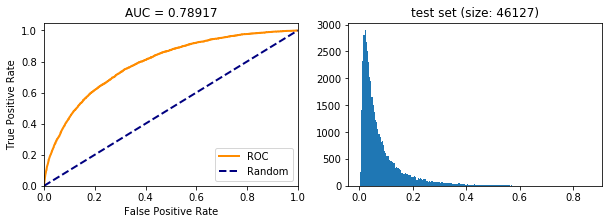

In [9]:
def visualize_auc(pdf, tvt_code, res_model):
    # get Xy and predict
    X, y = get_Xy_from_pdf(pdf, res_model["features"], tvt_code)
    y_pred = res_model["xgb_model"].predict_proba(X)[:, 1]
    
    # get values
    auc_value = metrics.roc_auc_score(y, y_pred)
    res01 = metrics.roc_curve(y, y_pred)

    # plot
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange",lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy", label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f"%(auc_value))
    ax1.legend(loc="lower right")

    # prediction probability histogram
    ax2.set_title("{} set (size: {})".format(tvt_code, y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

# 
visualize_auc(pdf_features_label, "test", res_model)

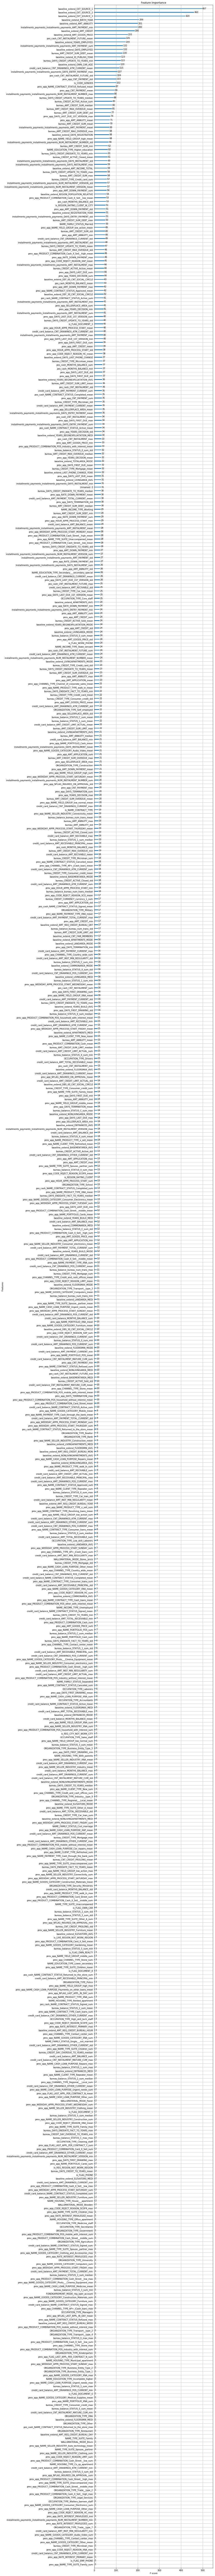

In [10]:
# 
fig_height = len(res_model["features"]) / 4
fig, ax = plt.subplots(figsize=(10, fig_height))
plot_importance(res_model["xgb_model"], ax=ax)
plt.show()

# Save submission

In [11]:
X_kaggle_test = pdf_features_label.query("tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = xgb_model.predict_proba(X_kaggle_test)[:, 1]
y_test_pred.mean()

0.07487694

In [12]:
SK_IDs = pdf_features_label.query("tvt_code == 'kaggle_test'")["SK_ID_CURR"].tolist()
pdf_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
pdf_submiss.to_csv("submissions/submission_baseline_{}.csv".format(version), index=False)
pdf_submiss.head()

,SK_ID_CURR,TARGET
0,100001,0.0391
1,100005,0.1485
2,100013,0.0313
3,100028,0.0313
4,100038,0.1743


![submission_baseline_v02](submissions/submission_baseline_v02.png "submission_baseline_v02")
![submission_baseline_v01](submissions/submission_baseline_v01.png "submission_baseline_v01")